[INFO] 2025-05-18 21:25:26 - <fbpinns.constants.Constants object at 0x7c714c0f1520>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class 'fbpinns.problems.WaveEquation2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0. , 0.5, 1. ]), array([0. , 0.5, 1. ])], 'subdomain_ws': [array([0.6, 0.6, 0.6]), array([0.6, 0.6, 0.6])], 'unnorm': (0.0, 5.0)}
network: <class 'fbpinns.networks.StackedChebyshevKAN'>
network_init_kwargs: {'dims': [2, 4, 1], 'degrees': [5, 5]}
n_steps: 1
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200, 200),)
n_test: (200, 200)
sampler: grid
optimiser: <function adam at 0x7c72341ee8e0>
optimiser_kwargs: {'learning_rate': 0.001}
seed: 0
summary_freq: 1000
test_freq: 1000
model_save_freq: 10000
show_figures: True
save_figures: Fa

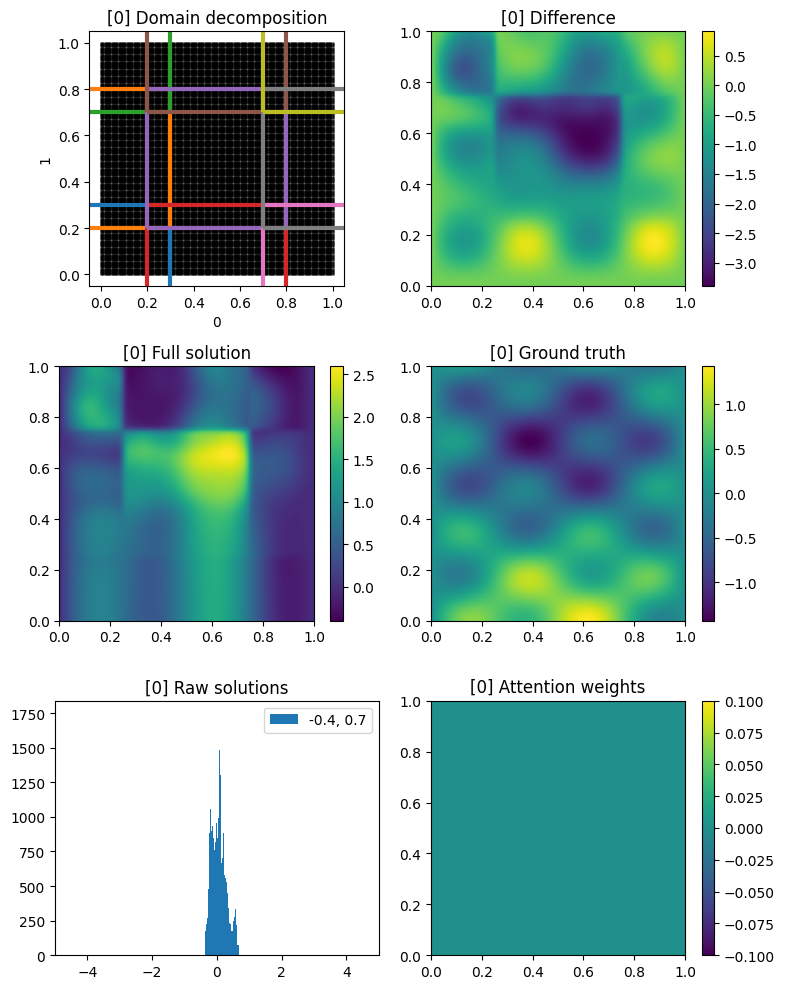

Traced<ShapedArray(float32[9])>with<JVPTrace> with
  primal = Traced<ShapedArray(float32[9])>with<JVPTrace> with
    primal = Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace>
    tangent = Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace>
  tangent = Traced<ShapedArray(float32[9])>with<JVPTrace> with
    primal = Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace>
    tangent = Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace>
Traced<ShapedArray(float32[9])>with<JVPTrace> with
  primal = Traced<ShapedArray(float32[9])>with<JVPTrace> with
    primal = Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace>
    tangent = Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace>
  tangent = Traced<ShapedArray(float32[9])>with<JVPTrace> with
    primal = Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace>
    tangent = Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace>
[INFO] 2025-05-18 21:25:39 - [i: 1/1] Training complete
[INFO] 2025-05-18 21:25:39 - [i: 1/1] Total 

In [1]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, StackedChebyshevKAN, StackedLegendreKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.problems import WaveEquation2D

subdomain_xs=[np.linspace(0,1,3), np.linspace(0,1,3)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        # c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 1.2),
        unnorm=(0.,5.),
    ),
    network=StackedChebyshevKAN,
    network_init_kwargs = dict(
        dims=[2, 4, 1],
        degrees=[5, 5]
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=1,
    clear_output=False,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=40000
        ),
    )

run = FBPINNTrainer(c)
all_params = run.train()

In [2]:
l1 = all_params[0]['trainable']['network']['subdomain']['coeffs_list'][0][4]
l2 = all_params[0]['trainable']['network']['subdomain']['coeffs_list'][1][4]
l1.shape, l2.shape

((2, 4, 6), (4, 1, 6))

In [3]:
points = RectangularDomainND.sample_interior(all_params=all_params[0], key=None, sampler="grid", batch_shape=c.n_test)
points.shape

(40000, 2)

In [4]:
from fbpinns.networks import LegendreKAN

out = points
out = ChebyshevKAN.forward(coeffs=l1, kind=2, x=out)
out = ChebyshevKAN.forward(coeffs=l2, kind=2, x=out)
out = WaveEquation2D.constraining_fn(all_params[0], points, out)
out.shape

(40000, 1)

In [5]:
np_out = np.array(out)
out.reshape(200, 200, 1)[70:140, 70:140, :].transpose(2, 0, 1).shape

(1, 70, 70)

In [6]:
import matplotlib.pyplot as plt

def plot_sch(data_list):
    # Example: generating some data of shape (2, 200, 200) (real and imaginary)
    data = data_list
    n_fields, Ny, Nx = data.shape
    y = np.arange(Ny)
    x = np.arange(Nx)
    X, Y = np.meshgrid(x, y)
    
    titles = ['wave']  # extend or truncate as needed

    # create one tall figure with n_fields rows
    fig = plt.figure(figsize=(8, 4 * n_fields))
    for i in range(n_fields):
        ax = fig.add_subplot(n_fields, 1, i+1, projection='3d')
        # 100 levels; use ax.contour3D (alias for Axes3D.contour)
        cont = ax.contour3D(X, Y, data[i], 100, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('value')
        ax.set_title(titles[i] if i < len(titles) else f'field {i}')
    plt.tight_layout()
    plt.show()

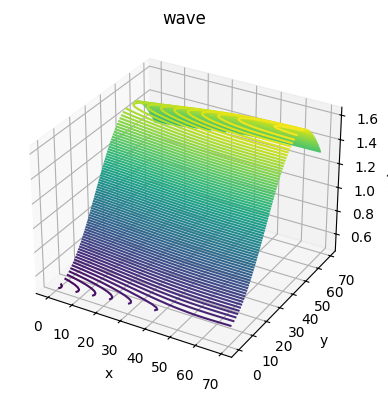

In [7]:
plot_sch(out.reshape(200, 200, 1)[70:140, 70:140, :].transpose(2, 0, 1))

In [8]:
decomp = RectangularDecompositionND
from jax import vmap
import fbpinns.windows as windows

def norm_fn(params, x):
    xmin, xmax = params["static"]["decomposition"]["subdomain"]["params"][:2]
    mu, sd = (xmax+xmin)/2, (xmax-xmin)/2
    return (x-mu)/sd

def unnorm_fn(params, u):
    params = params["static"]["decomposition"]["subdomain"]["params"]
    mu, sd = params[5][0]
    return (u-mu)/sd

def net(params, x, model_i=4):
    layer1 = params['trainable']['network']['subdomain']['coeffs_list'][0][model_i]
    layer2 = params['trainable']['network']['subdomain']['coeffs_list'][1][model_i]

    o = x
    o = ChebyshevKAN.forward(coeffs=layer1, kind=2, x=o)
    o = ChebyshevKAN.forward(coeffs=layer2, kind=2, x=o)
    return o

def window(params, x):
    params = params["static"]["decomposition"]["subdomain"]["params"]
    return params[4]*windows.cosine(*params[:2], x)+(1-params[4])

def foo(params, x, norm, network_fn, unnorm):
    normed = norm(params, x)
    uraw = network_fn(params, normed)
    unnormed = unnorm(params, uraw)
    w = window(params, x)
    return unnormed, w

points_split_by_region, w = vmap(foo, in_axes=(None,0,None, None, None))(all_params[0], points, norm_fn, net, unnorm_fn)
points_split_by_region.shape

print(jnp.unique(w))

[0.]


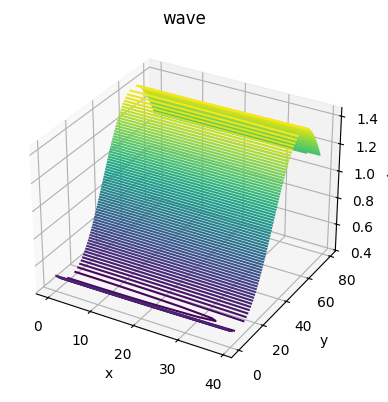

In [9]:
constr = WaveEquation2D.constraining_fn(all_params[0], points, points_split_by_region.sum(axis=1))
plot_sch(constr.reshape(200, 200, 1)[60:140, :40, :].transpose(2, 0, 1))

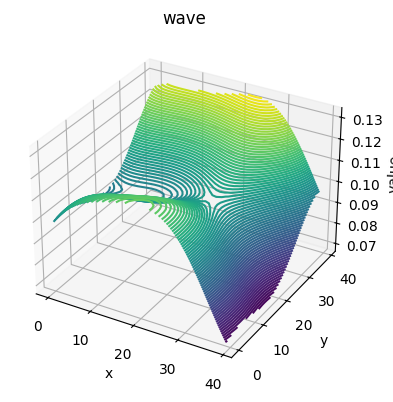

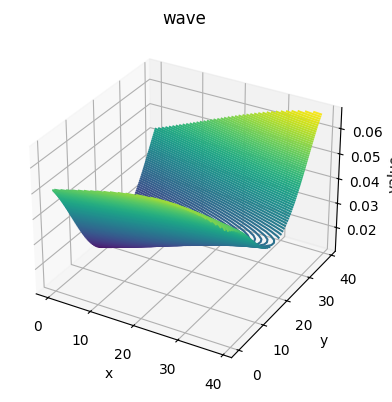

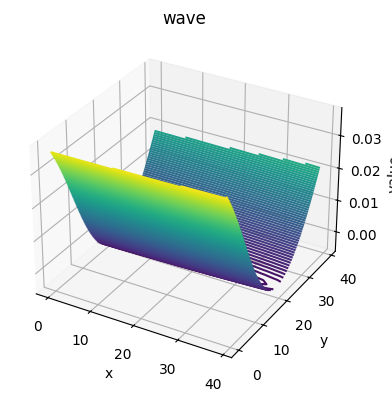

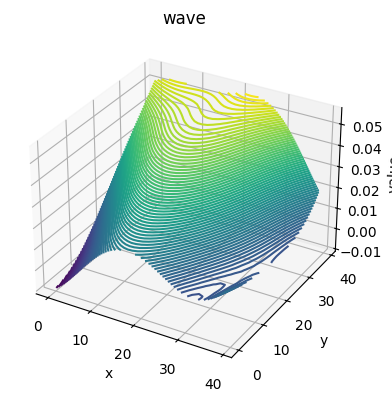

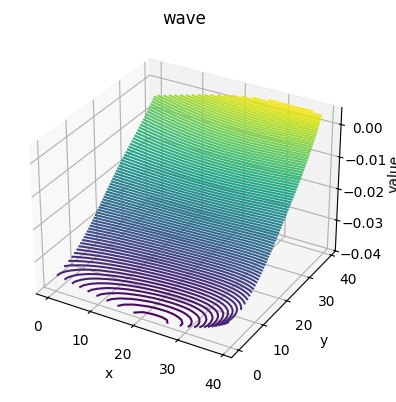

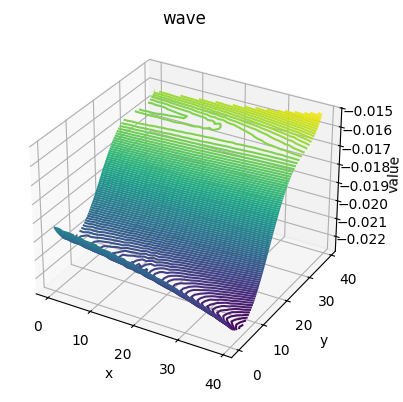

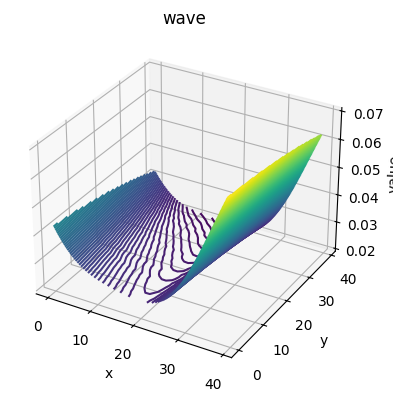

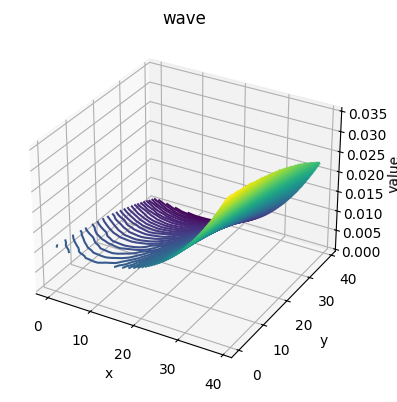

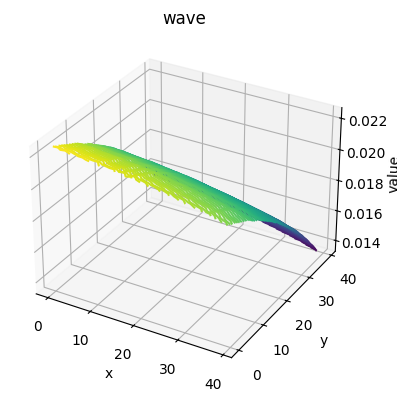

In [10]:
for i in range(9):
    plot_sch(points_split_by_region[:, i, :].reshape(200, 200, 1)[:40, :40, :].transpose(2, 0, 1))

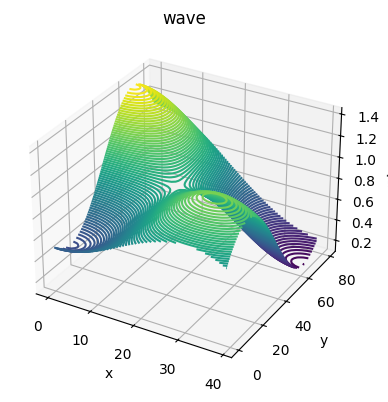

In [11]:
with open('/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave/CKAN_8/test_exact.npy', 'rb') as f:
    exact_wave = np.load(f).reshape(200, 200, -1)
plot_sch(exact_wave[60:140, :40, :].transpose(2, 0, 1))